# Tune In: Decision Threshold Optimization with scikit-learn's TunedThresholdClassifierCV

The 1.5 release of scikit-learn includes a new class, [TunedThresholdClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TunedThresholdClassifierCV.html), that makes it easier to optimize decision thresholds from scikit-learn classifiers. A decision threshold is a cut-off point that converts predicted probabilities output by a machine learning model into discrete classes. The default decision threshold of the `.predict()` method from scikit-learn classifiers in a binary classification setting is 0.5. Although this is a sensible default, it is rarely the best choice for classification tasks.

The goal of this post is to introduce the TunedThresholdClassifierCV class and demonstrate how it can be used to optimize decision thresholds for various binary classification tasks. This new class will help bridge the gap between data scientists who build models and business stakeholders who make decisions based on the model's output. By fine-tuning the decision thresholds, data scientists can enhance model performance and better align with business objectives.

This post will cover the following situations where tuning decision thresholds is beneficial:
1. Maximizing a metric: Use this when choosing a threshold that maximizes a scoring metric, like the F1 score.
2. Cost-sensitive learning: Adjust the threshold when the cost of misclassifying a false positive is not equal to the cost of misclassifying a false negative and you have an estimate of the costs.
3. Tuning under constraints: Optimize the operating point on the ROC or precision-recall curve to meet specific performance constraints.

Datasets and code used in this post are avaialble on [GitHub](https://github.com/arvkevi/tunein-blog).

Let's get started!
First, import the necessary libraries, read the data, and split training and test data.

In [18]:
%config InlineBackend.figure_format = 'retina'

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    RocCurveDisplay,
    f1_score,
    make_scorer,
    recall_score,
    roc_curve,
    confusion_matrix,
)
from sklearn.model_selection import TunedThresholdClassifierCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

RANDOM_STATE = 26120

## Maximizing a metric
Before starting the model-building process in any machine learning project, it is crucial to work with stakeholders to determine which metric(s) to optimize. Making this decision early ensures that the project aligns with its intended goals.

Using an accuracy metric in fraud detection use cases to evaluate model performance is not ideal because the data is often imbalanced, with most transactions being non-fraudulent. The F1 score is the harmonic mean of precision and recall and is a better metric for imbalanced datasets, like fraud detection. Let's use the `TunedThresholdClassifierCV` class to optimize the decision threshold of a logistic regression model to maximize the F1 score.

We'll use the [Kaggle Credit Card Fraud Detection dataset](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) to introduce the first situation where we need to tune a decision threshold. First, split the data into train and test sets, then create a scikit-learn pipeline to scale the data and train a logistic regression model. Fit the pipeline on the training data so we can compare the original model performance with the tuned model performance.

In [20]:
creditcard = pd.read_csv("data/creditcard.csv")
y = creditcard["Class"]
X = creditcard.drop(columns=["Class"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Only Time and Amount need to be scaled
original_fraud_model = make_pipeline(
    ColumnTransformer(
        [("scaler", StandardScaler(), ["Time", "Amount"])],
        remainder="passthrough",
        force_int_remainder_cols=False,
    ),
    LogisticRegression(),
)
original_fraud_model.fit(X_train, y_train);

No tuning has happened yet, but it's coming in the next code block. The arguments for `TunedThresholdClassifierCV` are similar to other `CV` classes in scikit-learn, such as [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). At a minimum, the user only needs to pass the orginal estimator and `TunedThresholdClassifierCV` will store the decision threshold that maximimizes balanced accuracy (default) using 5-fold stratified K-fold cross-validation (default). It also uses this threshold when calling `.predict()`. However, any scikit-learn metric (or callable) can be used as the `scoring` metric. Additionaly, the user can pass the familiar `cv` argument to customize the cross-validation strategy.

Create the `TunedThresholdClassifierCV` instance and fit the model on the training data. Pass the original model and set the scoring to be "f1". We'll also want to set `store_cv_results=True` to access the thresholds evaluated during cross-validation for visualization.

In [21]:
tuned_fraud_model = TunedThresholdClassifierCV(
    original_fraud_model,
    scoring="f1",
    store_cv_results=True,
)

tuned_fraud_model.fit(X_train, y_train)

# average F1 across folds
avg_f1_train = tuned_fraud_model.best_score_
# Compare F1 in the test set for the tuned model and the original model
f1_test = f1_score(y_test, tuned_fraud_model.predict(X_test))
f1_test_original = f1_score(y_test, original_fraud_model.predict(X_test))

print(f"Average F1 on the training set: {avg_f1_train:.3f}")
print(f"F1 on the test set: {f1_test:.3f}")
print(f"F1 on the test set (original model): {f1_test_original:.3f}")
print(f"Threshold: {tuned_fraud_model.best_threshold_: .3f}")

Average F1 on the training set: 0.784
F1 on the test set: 0.796
F1 on the test set (original model): 0.733
Threshold:  0.071


Now that we've found the threhsold that maximizes the F1 score, check `tuned_fraud_model.best_score_` to find out what the best average F1 score was across folds in cross-validation. We can also see which threshold generated those results using `tuned_fraud_model.best_threshold_`. You can visualize the metric scores across the decision thresholds during cross-validation using the `objective_scores_` and `decision_thresholds_` attributes:

Text(0.5, 1.0, 'F1 score vs. Decision threshold -- Cross-validation')

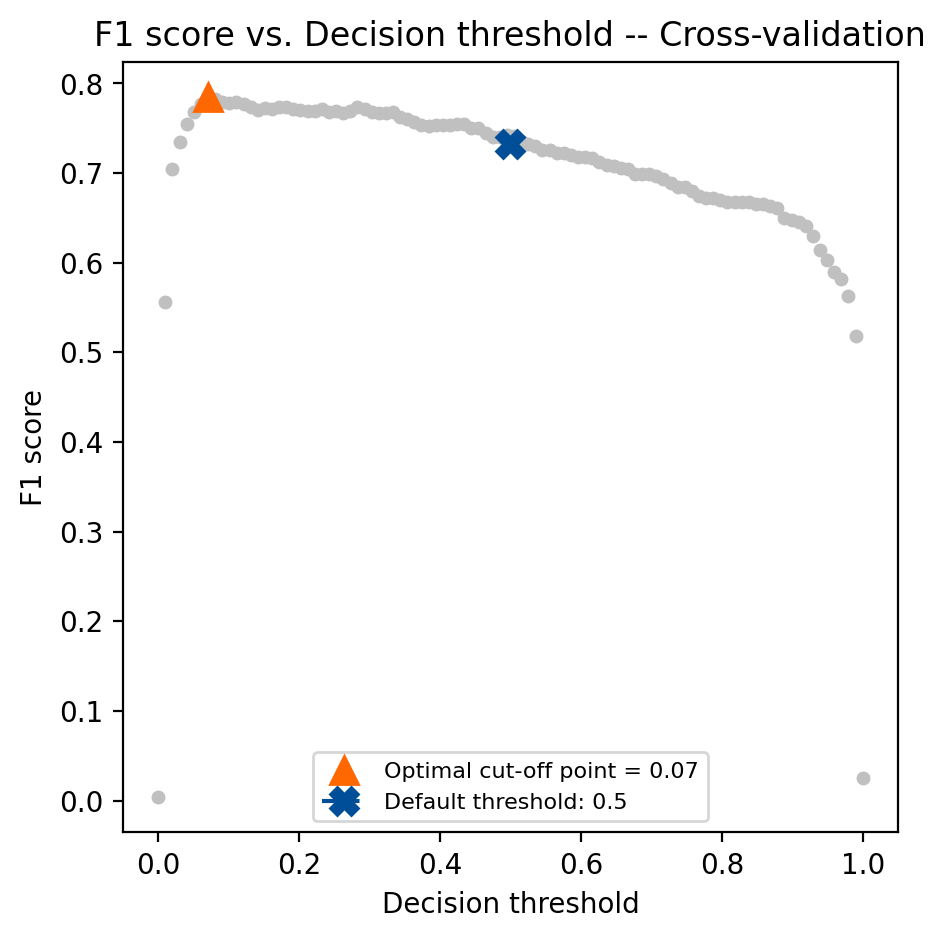

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(
    tuned_fraud_model.cv_results_["thresholds"],
    tuned_fraud_model.cv_results_["scores"],
    marker="o",
    linewidth=1e-3,
    markersize=4,
    color="#c0c0c0",
)
ax.plot(
    tuned_fraud_model.best_threshold_,
    tuned_fraud_model.best_score_,
    "^",
    markersize=10,
    color="#ff6700",
    label=f"Optimal cut-off point = {tuned_fraud_model.best_threshold_:.2f}",
)
ax.plot(
    0.5,
    f1_test_original,
    label="Default threshold: 0.5",
    color="#004e98",
    linestyle="--",
    marker="X",
    markersize=10,
)
ax.legend(fontsize=8, loc="lower center")
ax.set_xlabel("Decision threshold", fontsize=10)
ax.set_ylabel("F1 score", fontsize=10)
ax.set_title("F1 score vs. Decision threshold -- Cross-validation", fontsize=12)

In [23]:
# Check that the coefficients from the original model and the tuned model are the same
assert (tuned_fraud_model.estimator_[-1].coef_ ==
        original_fraud_model[-1].coef_).all()

We've used the same underlying logistic regression model to evaluate two different decision thresholds. The underlying models are the same, evidenced by the coefficient equality in the assert statement above. Optimization in `TunedThresholdClassifierCV` is achieved using post-processing techniques, which are applied directly to the predicted probabilities output by the model. However, it's important to note that `TunedThresholdClassifierCV` uses cross-validation by default to find the decision threshold to avoid overfitting to the training data.

## Cost-sensitive learning

Cost-sensitive learning is a type of machine learning that assigns a cost to each type of misclassification, which translates model performance to units that stakeholders understand, like dollars saved.

We will use the [TELCO customer churn dataset](https://accelerator.ca.analytics.ibm.com/bi/?perspective=authoring&pathRef=.public_folders%2FIBM%2BAccelerator%2BCatalog%2FContent%2FDAT00148&id=i9710CF25EF75468D95FFFC7D57D45204&objRef=i9710CF25EF75468D95FFFC7D57D45204&action=run&format=HTML&cmPropStr=%7B%22id%22%3A%22i9710CF25EF75468D95FFFC7D57D45204%22%2C%22type%22%3A%22reportView%22%2C%22defaultName%22%3A%22DAT00148%22%2C%22permissions%22%3A%5B%22execute%22%2C%22read%22%2C%22traverse%22%5D%7D), a binary classification dataset to demonstrate the value of cost-sensitive learning. The goal is to predict whether a customer will churn or not, given features about the customer's demographics, contract details, and other technical information about the customer's account. The motivation to use this dataset (and some of the code) is from [Dan Becker's course on decision threshold optimization](https://www.wandb.courses/courses/decision-optimization).

In [121]:
data = pd.read_excel("data/Telco_customer_churn.xlsx")
drop_cols = [
    "Count", "Country", "State", "Lat Long", "Latitude", "Longitude",
    "Zip Code", "Churn Value", "Churn Score", "CLTV", "Churn Reason"
]
data.drop(columns=drop_cols, inplace=True)

# Preprocess the data
data["Churn Label"] = data["Churn Label"].map({"Yes": 1, "No": 0})
data.drop(columns=["Total Charges"], inplace=True)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=["Churn Label"]),
    data["Churn Label"],
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=data["Churn Label"],
)

Set up a basic pipeline for processing the data and generating predicted probabilities with a random forest model. This will serve as a baseline to compare to the `TunedThresholdClassifierCV`.

In [117]:
preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(handle_unknown="infrequent_if_exist"),
                   selector(dtype_include="object"))],
    remainder="passthrough",
)

original_churn_model = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=RANDOM_STATE)
)
original_churn_model.fit(X_train.drop(columns=["CustomerID"]), y_train);

The choice of preprocessing and model type is not important for this tutorial. The company wants to offer discounts to customers who are predicted to churn. During collaboration with stakeholders, you learn that giving a discount to a customer who will not churn (a false positive) would cost $80. You also learn that it's worth $200 to offer a discount to a customer who would have churned. You can represent this relationship in a cost matrix:

In [118]:
def cost_function(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    cost_matrix = np.array([[0, -80], [0, 200]])
    return np.sum(cm * cost_matrix)


cost_scorer = make_scorer(cost_function, neg_label=0, pos_label=1)

We also wrapped the cost function in a scikit-learn custom scorer. This scorer will be used as the `scoring` argument in the TunedThresholdClassifierCV and to evaluate profit on the test set.

In [119]:
tuned_churn_model = TunedThresholdClassifierCV(
    original_churn_model,
    scoring=cost_scorer,
    store_cv_results=True,
)

tuned_churn_model.fit(X_train.drop(columns=["CustomerID"]), y_train)

# Calculate the profit on the test set
original_model_profit = cost_scorer(
    original_churn_model, X_test.drop(columns=["CustomerID"]), y_test
)
tuned_model_profit = cost_scorer(
    tuned_churn_model, X_test.drop(columns=["CustomerID"]), y_test
)

print(f"Original model profit: {original_model_profit}")
print(f"Tuned model profit: {tuned_model_profit}")

Original model profit: 29640
Tuned model profit: 35600


The profit is higher in the tuned model compared to the original. Again, we can plot the objective metric against the decision thresholds to visualize the decision threshold selection on training data during cross-validation:

Text(0.5, 1.0, 'Objective score as a function of the decision threshold')

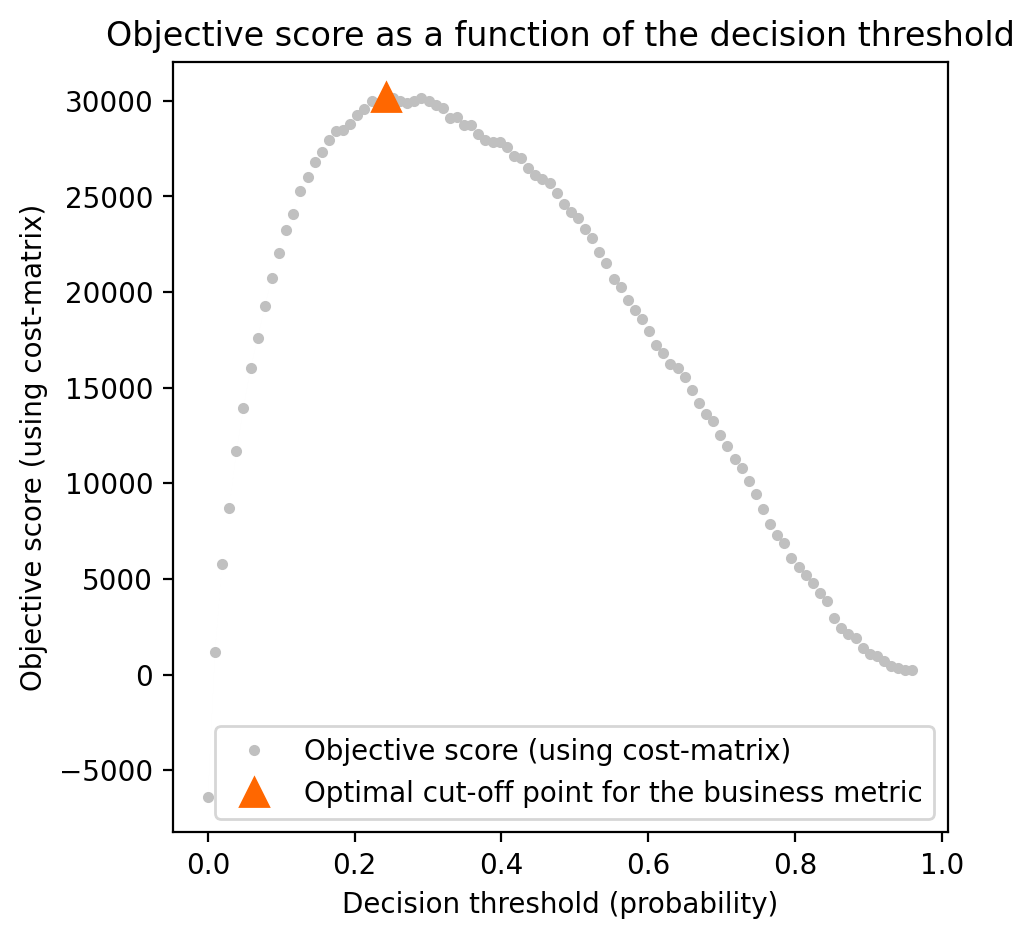

In [120]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(
    tuned_churn_model.cv_results_["thresholds"],
    tuned_churn_model.cv_results_["scores"],
    marker="o",
    markersize=3,
    linewidth=1e-3,
    color="#c0c0c0",
    label="Objective score (using cost-matrix)",
)
ax.plot(
    tuned_churn_model.best_threshold_,
    tuned_churn_model.best_score_,
    "^",
    markersize=10,
    color="#ff6700",
    label="Optimal cut-off point for the business metric",
)
ax.legend()
ax.set_xlabel("Decision threshold (probability)")
ax.set_ylabel("Objective score (using cost-matrix)")
ax.set_title("Objective score as a function of the decision threshold")

In reality, assigning a static cost to all instances that are misclassified in the same way is not realistic from a business perspective. There are more advanced methods to tune the threshold by assigning a weight to each instance in the dataset. This is covered in [scikit-learn's cost-sensitive learning example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cost_sensitive_learning.html#sphx-glr-auto-examples-model-selection-plot-cost-sensitive-learning-py).

## Tuning under constraints  

This method is not covered in the scikit-learn documentation currently, but is a common business case for binary classification use cases. The tuning under constraint method finds a decision threshold by identifying a point on either the ROC or precision-recall curves. The point on the curve is the maximum value of one axis while constraining the other axis. For this walkthrough, we'll be using the Pima Indians diabetes dataset. This is a binary classification task to predict if an individual has diabetes. 

Imagine that your model will be used as a screening test for an average-risk population applied to millions of people. There are an estimated 38 million people with diabetes in the US. This is roughly 11.6% of the population, so the model's specificity should be high so it doesn't misdiagnose millions of people with diabetes and refer them to unnecessary confirmatory testing. Suppose your imaginary CEO has communicated that they will not tolerate more than a 2% false positive rate. Let's build a model that achieves this using `TunedThresholdClassifierCV`. 

For this part of the tutorial, we'll define a constraint function that will be used to find the maximum true positive rate at a 2% false positive rate.

In [29]:
def max_tpr_at_tnr_constraint_score(y_true, y_pred, max_tnr=0.5):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, drop_intermediate=False)
    tnr = 1 - fpr
    tpr_at_tnr_constraint = tpr[tnr >= max_tnr].max()
    return tpr_at_tnr_constraint


max_tpr_at_tnr_scorer = make_scorer(
    max_tpr_at_tnr_constraint_score, max_tnr=0.98)

In [30]:
data = pd.read_csv("data/diabetes.csv")

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=["Outcome"]),
    data["Outcome"],
    stratify=data["Outcome"],
    test_size=0.2,
    random_state=RANDOM_STATE,
)

Build two models, one logistic regression to serve as a baseline model and the other, `TunedThresholdClassifierCV` which will wrap the baseline logistic regression model, to achieve the goal outlined by the CEO. In the tuned model, set `scoring=max_tpr_at_tnr_scorer`. Again, the choice of model and preprocessing is not important for this tutorial.

In [31]:
# A baseline model
original_model = make_pipeline(
    StandardScaler(), LogisticRegression(random_state=RANDOM_STATE)
)
original_model.fit(X_train, y_train)

# A tuned model
tuned_model = TunedThresholdClassifierCV(
    original_model,
    thresholds=np.linspace(0, 1, 150),
    scoring=max_tpr_at_tnr_scorer,
    store_cv_results=True,
    cv=8,
    random_state=RANDOM_STATE,
)
tuned_model.fit(X_train, y_train);

Compare the difference between the default decision threshold from scikit-learn estimators, 0.5, and one found using the tuning under constraint approach on the ROC curve.

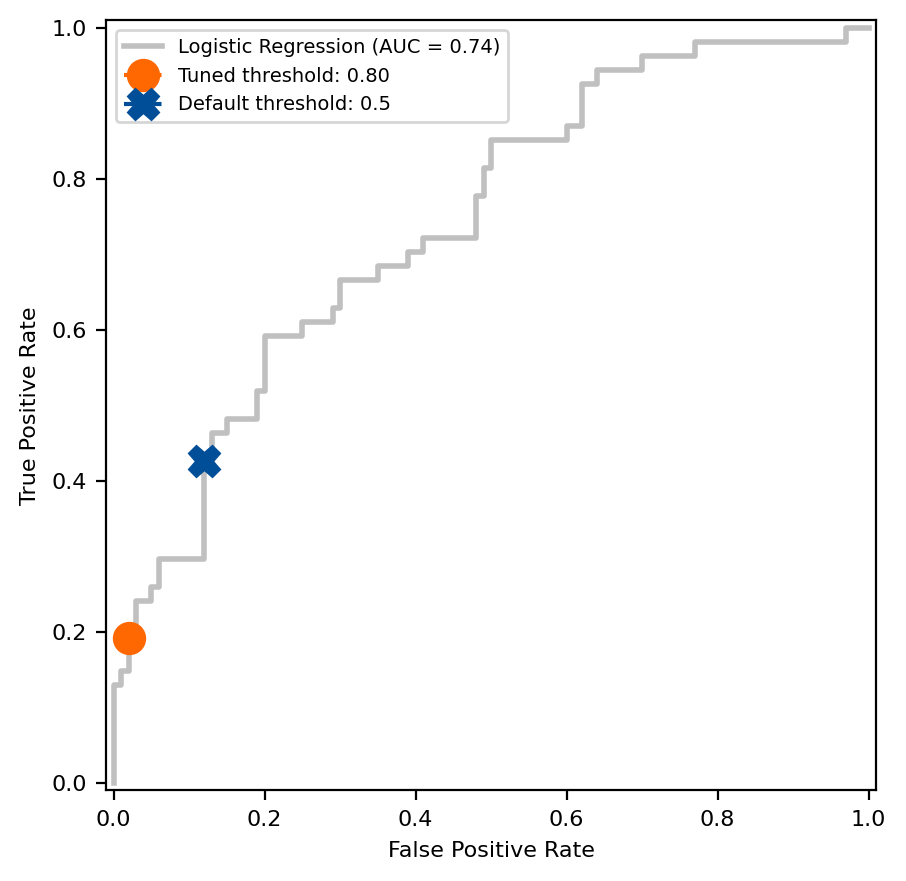

In [32]:
# Get the fpr and tpr of the original model
original_model_proba = original_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, original_model_proba)
closest_threshold_to_05 = (np.abs(thresholds - 0.5)).argmin()
fpr_orig = fpr[closest_threshold_to_05]
tpr_orig = tpr[closest_threshold_to_05]

# Get the tnr and tpr of the tuned model
max_tpr = tuned_model.best_score_
constrained_tnr = 0.98

# Plot the ROC curve and compare the default threshold to the tuned threshold
fig, ax = plt.subplots(figsize=(5, 5))
# Note that this will be the same for both models
disp = RocCurveDisplay.from_estimator(
    original_model,
    X_test,
    y_test,
    name="Logistic Regression",
    color="#c0c0c0",
    linewidth=2,
    ax=ax,
)
disp.ax_.plot(
    1 - constrained_tnr,
    max_tpr,
    label=f"Tuned threshold: {tuned_model.best_threshold_:.2f}",
    color="#ff6700",
    linestyle="--",
    marker="o",
    markersize=11,
)
disp.ax_.plot(
    fpr_orig,
    tpr_orig,
    label="Default threshold: 0.5",
    color="#004e98",
    linestyle="--",
    marker="X",
    markersize=11,
)
disp.ax_.set_ylabel("True Positive Rate", fontsize=8)
disp.ax_.set_xlabel("False Positive Rate", fontsize=8)
disp.ax_.tick_params(labelsize=8)
disp.ax_.legend(fontsize=7)

The tuned under constraint method found a threshold of 0.80 which resutled in an average sensitivity of 19.2% during cross-validation on the training data. See how the threshold holds up in the test set by comparing the sensitivity and specificity. Did the model meet the CEO's specificty requirement in the test set?

In [33]:
# Average sensitivity and specificity on the training set
avg_sensitivity_train = tuned_model.best_score_

# Call predict from tuned_model to calculate sensitivity and specificity on the test set
specificity_test = recall_score(
    y_test, tuned_model.predict(X_test), pos_label=0)
sensitivity_test = recall_score(y_test, tuned_model.predict(X_test))

print(f"Average sensitivity on the training set: {avg_sensitivity_train:.3f}")
print(f"Sensitivity on the test set: {sensitivity_test:.3f}")
print(f"Specificity on the test set: {specificity_test:.3f}")

Average sensitivity on the training set: 0.192
Sensitivity on the test set: 0.148
Specificity on the test set: 0.990


## Conclusion

The new `TunedThresholdClassifierCV` class is a powerful tool that can help you become a better data scientist by sharing with business leaders how you arrived at a decision threshold. You learned how to use the new scikit-learn `TunedThresholdClassifierCV` class to maximize a metric, perform cost-sensitive learning, and tune a metric under constraint. This tutorial was not intended to be comprehensive or advanced. I wanted to introduce the new feature and highlight its power and flexibility in solving binary classification problems. Please check out the scikit-learn documentation, user guide, and examples for thorough usage examples.

A huge shoutout to [Guillaume Lemaitre](https://github.com/glemaitre) for his work on this feature.

Thanks for reading. Happy tuning.

Data Licenses:
Credit card fraud: DbCL
Pima Indians diabetes: CC0
TELCO churn: [commercial use OK](https://developer.ibm.com/terms/download-of-content-agreement/)